In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import re
import urllib
import time
import math
import eli5

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import forest

from bs4 import BeautifulSoup
from collections import Counter
from datetime import datetime
from nltk.corpus import stopwords
from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold

# Predicting Film Box Office Revenue

This notebook follows Kaggle's Box Office Prediction competition. The competition's official evaluation metric is the Root-Mean-Squared-Logarithmic-Error (RMSLE). I will go through some EDA, feature engineering and model development, and explain the thinking behind most of my decisions along the way. To start with, let's first load the data:

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Training samples: {}'.format(len(train)))
print('Test samples: {}'.format(len(test)))
train.head()

Training samples: 3000
Test samples: 4398


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


There are very few training examples to work with. When it comes to the columns, there is a variety of different data - from text, to numerical, a date and some ID's. A few of the text features will need additional formatting to extract useful information out of them.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

Quite a few of the columns have null values and with some, such as "belongs_to_collection" and "homepage", null is the most common value. I will need to decide how best to deal with the nulls in each case individually. 

However, let's first address another issue. While the budget column seems fine (no null values), at closer inspection there is a problem:

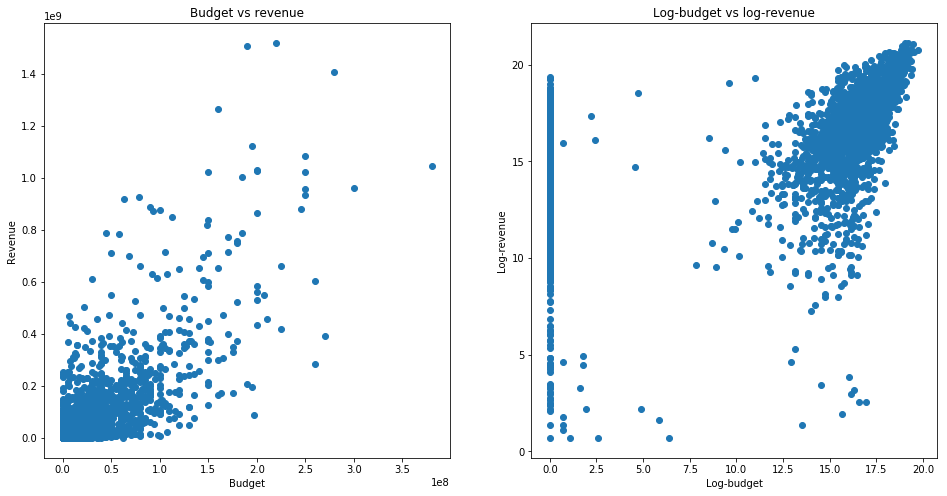

Fraction of training samples where budget equals zero: 0.27066666666666667
Fraction of test samples where budget equals zero: 0.27535243292405637


In [4]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.title('Budget vs revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.scatter(train.budget, train.revenue)
plt.subplot(1, 2, 2)
plt.title('Log-budget vs log-revenue')
plt.xlabel('Log-budget')
plt.ylabel('Log-revenue')
plt.scatter(np.log1p(train.budget), np.log1p(train.revenue))
plt.show()

print(f'Fraction of training samples where budget equals zero: {len(train[train.budget == 0]) / len(train)}')
print(f'Fraction of test samples where budget equals zero: {len(test[test.budget == 0]) / len(test)}')

Almost a third of the budget data is basically null, since I don't think all those film were made for free (see the number of zero-budget films). There are two options for filling in some missing budgets - manual and using code. Letting Python do the dirty work is obviously the better solution. However, in this case I couldn't think of a good way to automate the process. There is an IMDB ID in the data (and it's non-null for all samples), but almost all of the data with missing budget don't have it included on IMDB either. Besides, I'd need to get a written consent by IMDB, as written in their conditions of use, which I wasn't prepared to deal with for a small fraction of the missing data. Since the data samples are so few anyway, I decided to try and fix some of the values manually, hopefully contributing to a small improvement in the model performance. I got some values from a Kaggle kernel (link to the kernel is in the code below).

In [5]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       # Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

Initially, I had gathered many more values manually from the Internet. The result of my effort was a worse model and terrible test set results. After the initial confusion and a bit of deliberation, I believe I understand why this is. The rows printed below might provide a hint:

In [6]:
train[(train.budget < 1000)&(train.budget > 0)][['id', 'title', 'imdb_id', 'budget', 'revenue']]

,id,title,imdb_id,budget,revenue
334,335,Saamy,tt0376144,1,3
347,348,The Wind in the Willows,tt0118172,12,1
639,640,Pollock,tt0183659,6,8
695,696,Tere Naam,tt0374271,1,2
1198,1199,Every Which Way But Loose,tt0077523,5,85
1346,1347,East of Eden,tt0048028,1,5
1541,1542,All at Once,tt3805180,1,3
1754,1755,Mute Witness,tt0110604,2,1
1800,1801,The Cherry Orchard,tt0144134,5,135
1917,1918,The Merry Widow,tt0016104,592,1


There are way too many mistakes in the data. First of all, the budgets and revenues are at different scales. I found that most values under 100 for both columns are expressed in millions, but not all - some are thousands. Some budgets/revenues I found baffling when looking up the values on IMDB, and discovered that someone actually put the movie runtime (in mins) as revenue. I fixed the scales, corrected some values and got a worse model. Why? Because after doing so, my training set, and the budget column of my test set, were coming from "a different distribution" compared to the target values (test set revenues), i.e. they were closer to correct values, while the target revenues expected from the competition were still of various scales and contained all kinds of mistakes (not that I managed to fix all training data mistakes manually myself...)

Interestingly, the corrections I got from the Kaggle kernel (see corrections above for link) led to an improvement in the model, so maybe the author had some insight I don't have.

In [7]:
id_regex = re.compile('(?<=\'id\': )\\d+')
name_regex = re.compile('(?<=\'name\': )\'(\\w+)\'')

def get_id(json_str):
    matches = id_regex.findall(json_str)
    if len(matches) == 0:
        return -1
    
    return int(matches[0])

def has_multiple_ids(json_str):
    matches = id_regex.findall(json_str)
    if len(matches) == 0:
        return -1
    
    return 1 if len(matches) > 1 else 0

def fix_date(date):
    year = str(date).split('/')[-1]
    if len(year) == 4:
        return date
    
    year = '20' + year if int(year) <= 19 else '19' + year
    return date[:-2] + year

In [8]:
test['revenue'] = -1
data = pd.concat([train, test])
train['log_revenue'] = np.log1p(train.revenue)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 23 columns):
id                       7398 non-null int64
belongs_to_collection    1481 non-null object
budget                   7398 non-null int64
genres                   7375 non-null object
homepage                 2366 non-null object
imdb_id                  7398 non-null object
original_language        7398 non-null object
original_title           7398 non-null object
overview                 7376 non-null object
popularity               7398 non-null float64
poster_path              7396 non-null object
production_companies     6984 non-null object
production_countries     7241 non-null object
release_date             7397 non-null object
runtime                  7392 non-null float64
spoken_languages         7336 non-null object
status                   7396 non-null object
tagline                  5938 non-null object
title                    7395 non-null object
Keywords           

In [9]:
data['in_collection'] = ~data.belongs_to_collection.isna()
data['collection_id'] = data.belongs_to_collection.fillna('').apply(get_id)
data = data.drop('belongs_to_collection', axis = 1)

I will now deal with the collections column - "belongs_to_collection". The only useful feature I can think of is whether the film is part of a collection at all. Dealing with specific collections might be useful in very limited cases. For example, grouping by collections and taking mean revenue, the Avengers movies stand out(bottom row below)

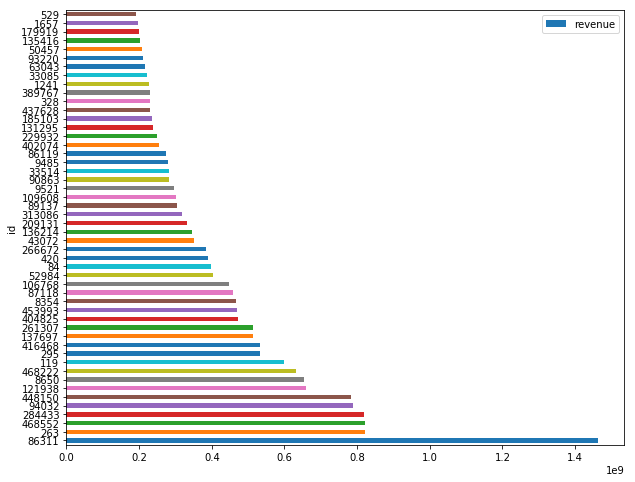

In [10]:
revenue_by_collection = data[['collection_id', 'revenue']]\
                            .groupby('collection_id')\
                            .mean()\
                            .sort_values('revenue', ascending = False)
            
revenue_by_collection['id'] = revenue_by_collection.index.tolist()
revenue_by_collection.head(50).plot('id', 'revenue', 'barh', figsize = (10, 8))

Seems like overkill to add a whole column just to possibly improve the score on a couple of movies from that specific collection.

In [11]:
data = data.drop('collection_id', axis = 1)

I will next examine the genres column. Some films can be associated with multiple genres. This seems like potentially useful information.

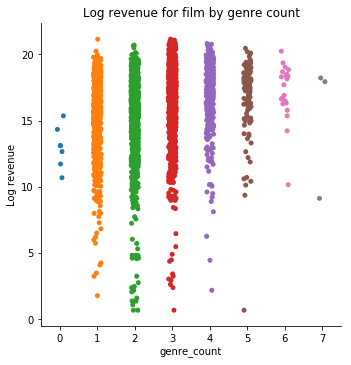

In [12]:
data['multi_genre'] = data.genres.fillna('').apply(has_multiple_ids)
data['genre_count'] = data.genres.fillna('').apply(lambda x: len(id_regex.findall(x)))
train['genre_count'] = data[data.revenue != -1]['genre_count']

sns.catplot(x = 'genre_count',
            y = 'log_revenue',
            data = train)
plt.ylabel('Log revenue')
plt.title('Log revenue for film by genre count')
plt.show()

The more genres the film covers, the higher the mean revenue seems to be, although the difference is not large. Let's look at specific genres

In [13]:
genres = data.genres.fillna('').apply(lambda x: '/'.join(name_regex.findall(x)))
genres_counts = dict()
for genre in genres:
    split = genre.split('/')
    for g in split:
        if g not in genres_counts:
            genres_counts[g] = 1
        else:
            genres_counts[g] += 1

genres_counts_df = pd.DataFrame.from_dict(genres_counts, orient = 'index')
genres_counts_df.columns = ['count']
genres_counts_df = genres_counts_df.drop(genres_counts_df.index[-1], axis = 0)

genres_counts_df = genres_counts_df.sort_values('count', ascending = False)
genres_counts_df.iloc[:10]

,count
Drama,3676
Comedy,2605
Thriller,1869
Action,1735
Romance,1435
Adventure,1116
Crime,1084
Horror,735
Family,675
Fantasy,628


In [14]:
def check_genre_occurrence(element, genre, max_genres = 7):
    all_genres = name_regex.findall(element)
    if len(all_genres) > max_genres:
        return False
    
    return genre in all_genres

def create_genre_cols(data, genres_counts, first_n):
    genres_fillna = data.genres.fillna('')
    for genre in genres_counts.iloc[:first_n].index.tolist():
        data[f'genre_{genre.lower()}'] = genres_fillna.apply(check_genre_occurrence, args = (genre, 7))
    
    return data

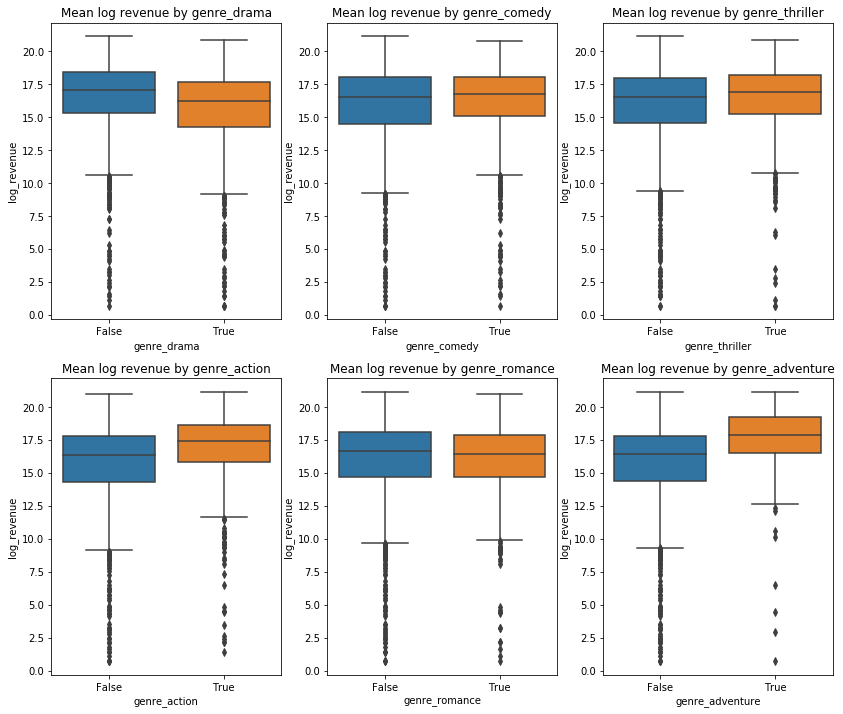

In [15]:
n_genres = 6
data = create_genre_cols(data, genres_counts_df, n_genres)
data['genres_NA'] = data.genres.isna()

genre_cols = [f'genre_{genre.lower()}' for genre in genres_counts_df.index.tolist()[:n_genres]]
train = data[data.revenue != -1].copy()
train['log_revenue'] = np.log1p(train.revenue)

plt.figure(figsize = (14, 12))
for idx, genre in enumerate(genre_cols):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(x = genre, y = 'log_revenue', data = train)
    plt.title(f'Mean log revenue by {genre.lower()}')

The homepage column is null in most of the samples. This is probably because most films were made before the Internet era. Still, it might prove useful to distinguish between films with and without a homepage.

In [16]:
data['has_homepage'] = ~data.homepage.isna()
data = data.drop('homepage', axis = 1)

# lowercase all column names
data.columns = [c.lower() for c in data.columns]

data = data.drop('genres', axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 31 columns):
id                      7398 non-null int64
budget                  7398 non-null int64
imdb_id                 7398 non-null object
original_language       7398 non-null object
original_title          7398 non-null object
overview                7376 non-null object
popularity              7398 non-null float64
poster_path             7396 non-null object
production_companies    6984 non-null object
production_countries    7241 non-null object
release_date            7397 non-null object
runtime                 7392 non-null float64
spoken_languages        7336 non-null object
status                  7396 non-null object
tagline                 5938 non-null object
title                   7395 non-null object
keywords                6729 non-null object
cast                    7372 non-null object
crew                    7360 non-null object
revenue                 7398 non-null 

Next stop - languages:

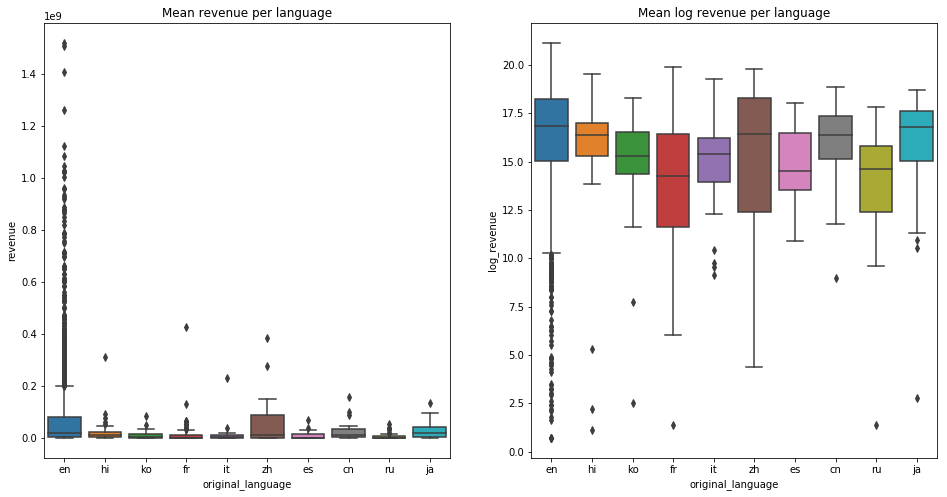

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue',
            data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue',
            data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

The only language that really stands out is English. In addition, it doesn't help that most other languages have only a few samples to represent them. The only feature I will get out of this column is whether the original language was English, or not.

In [18]:
data['language_en'] = data.original_language == 'en'
data = data.drop('original_language', axis = 1)

Let's check if we can get something out of the "original_title" column.

In [19]:
data.original_title.head(30)

0                         Hot Tub Time Machine 2
1       The Princess Diaries 2: Royal Engagement
2                                       Whiplash
3                                        Kahaani
4                                           마린보이
5         Pinocchio and the Emperor of the Night
6                                 The Possession
7                                   Control Room
8                         Muppet Treasure Island
9                                  A Mighty Wind
10                                         Rocky
11    Revenge of the Nerds II: Nerds in Paradise
12                               American Beauty
13                                       Be Cool
14                               Minority Report
15                                       Šišanje
16                                       Red Eye
17                           The Invisible Woman
18                                   Chalet Girl
19                                 Transporter 2
20                  

Perhaps there are some common words that appear in movie titles and correlate with some effect on the revenue?

In [20]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

title_tfidf = vectorizer.fit_transform(train['original_title'].fillna(''))
linreg = LinearRegression()
linreg.fit(title_tfidf, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+5.756,don t
+4.906,the secret
+4.707,age
+4.694,part ii
+4.413,know
+4.072,transformers
+3.948,witch
+3.860,the lost
+3.803,knight
+3.577,sea


Very similar ngrams seem to have opposite-sign weights. I guess the title of a movie is just too short to provide a useful feature.

In [21]:
data = data.drop(['original_title', 'poster_path', 'status'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 28 columns):
id                      7398 non-null int64
budget                  7398 non-null int64
imdb_id                 7398 non-null object
overview                7376 non-null object
popularity              7398 non-null float64
production_companies    6984 non-null object
production_countries    7241 non-null object
release_date            7397 non-null object
runtime                 7392 non-null float64
spoken_languages        7336 non-null object
tagline                 5938 non-null object
title                   7395 non-null object
keywords                6729 non-null object
cast                    7372 non-null object
crew                    7360 non-null object
revenue                 7398 non-null int64
in_collection           7398 non-null bool
multi_genre             7398 non-null int64
genre_count             7398 non-null int64
genre_drama             7398 non-null bool


In [22]:
data.production_countries.value_counts()[:60]

[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                               4339
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                268
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                          205
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                                   183
[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                       120
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                                  117
[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso_3166_

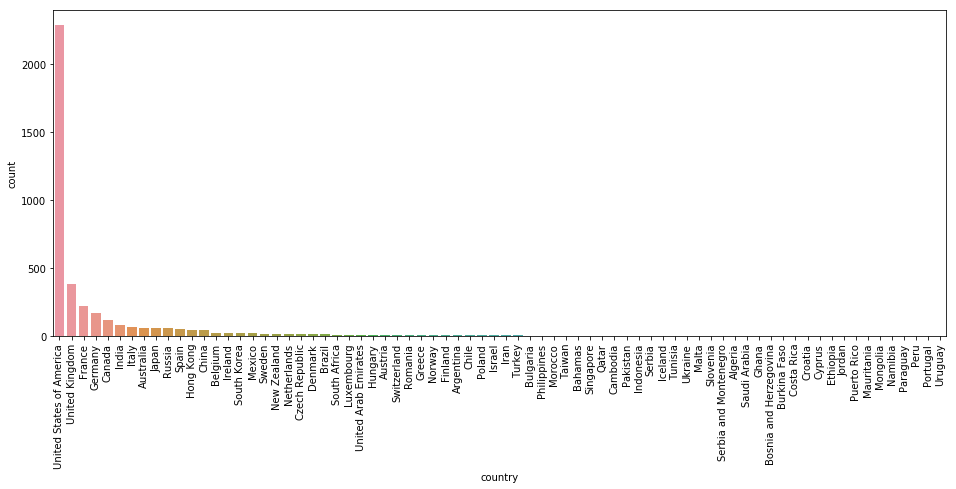

In [23]:
name_regex = re.compile(r'(?<=\'name\': )\'([\w ]+)\'')
production_countries = data[data.revenue != -1].production_countries.fillna('')\
                                .apply(lambda x: name_regex.findall(x))
    
production_countries = [pc for prod in production_countries for pc in prod]
counts = np.unique(production_countries, return_counts = True)
counts = pd.DataFrame(np.vstack(counts).T, columns=['country', 'count'])
counts['count'] = counts['count'].astype('int')

plt.figure(figsize=(16, 6))
plt.subplot(1, 1, 1)
g = sns.barplot('country', 'count', data = counts.sort_values(by='count', ascending = False))
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
plt.show()

The United States, as can be expected, is where the vast majority of films in the data were produced. However, there are a few more countries with enough entries that they should be considered.

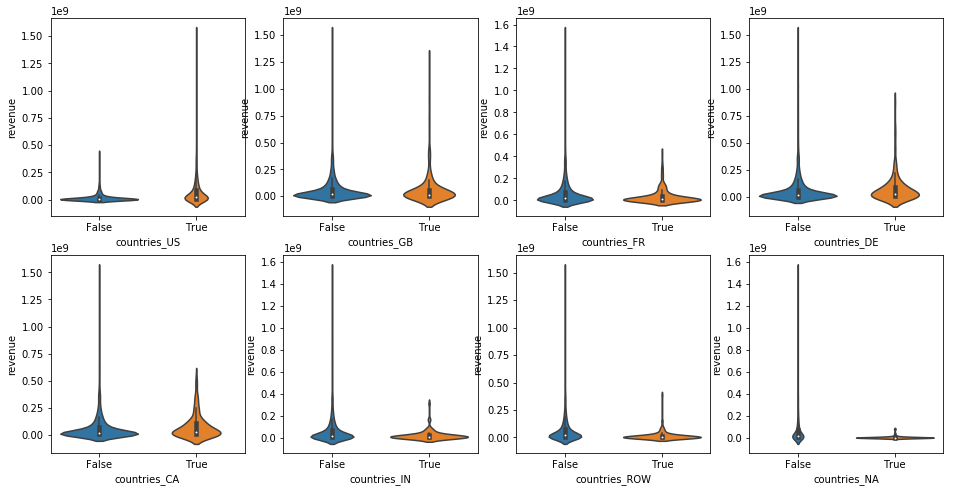

In [24]:
collab_US = data.production_countries.fillna('').str.contains('US')
data['countries_US'] = collab_US
collab_GB = data.production_countries.fillna('').str.contains('GB')
data['countries_GB'] = collab_GB
collab_FR = data.production_countries.fillna('').str.contains('FR')
data['countries_FR'] = collab_FR
collab_DE = data.production_countries.fillna('').str.contains('DE')
data['countries_DE'] = collab_DE
collab_CA = data.production_countries.fillna('').str.contains('CA')
data['countries_CA'] = collab_CA
collab_IN = data.production_countries.fillna('').str.contains('IN')
data['countries_IN'] = collab_IN
data['countries_ROW'] = ~(collab_US|collab_GB|collab_FR|collab_DE|collab_CA|collab_IN)
data.loc[data.production_countries.isna(), 'countries_ROW'] = False
data['countries_NA'] = data.production_countries.isna()
data = data.drop('production_countries', axis = 1)

country_cols = [col for col in data.columns if 'countries_' in col]
train = data[data.revenue != -1].copy()
train['log_revenue'] = np.log1p(train.revenue)
plt.figure(figsize=(16, 8))
for idx, col in enumerate(country_cols):
    plt.subplot(2, 4, idx + 1)
    sns.violinplot(x=col, y='revenue', data = train)

Let's see which are the top production companies:

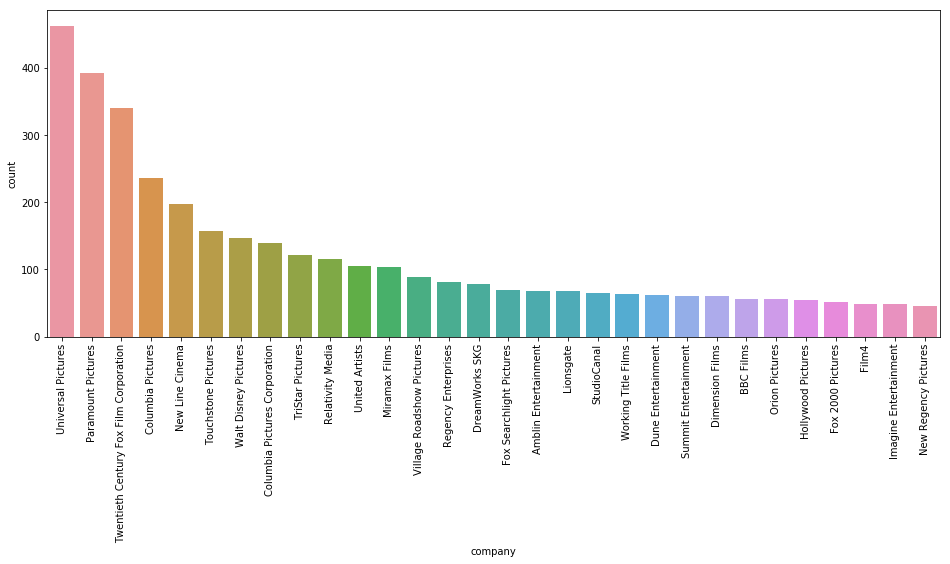

In [25]:
production_companies = data.production_companies.fillna('').apply(lambda x: name_regex.findall(x)).values
production_companies = np.array([prod_comp for prod_comps in production_companies
                                 for prod_comp in prod_comps])

counts = np.unique(production_companies, return_counts = True)
counts = pd.DataFrame(np.vstack(counts).T, columns=['company', 'count'])
counts['count'] = counts['count'].astype('int')

plt.figure(figsize=(16, 6))
plt.subplot(1, 1, 1)
g = sns.barplot('company', 'count', data = counts.sort_values(by='count', ascending = False).head(30))
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
plt.show()

It could be beneficial to highlight the biggest production studios in new features (also tried creating a small_studio feature but only made model worse):

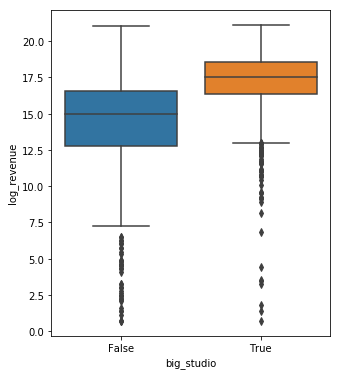

In [26]:
companies_ids = data.production_companies.fillna('').apply(lambda x: id_regex.findall(x)).values
companies_all = np.array([ci for c_id in companies_ids for ci in c_id])
companies_counts  = np.unique(companies_all, return_counts = True)

big_studio_threshold = 30
big_studios = companies_counts[0][companies_counts[1] >= big_studio_threshold]

data['big_studio'] = [any([company in big_studios for company in companies])\
                                 for companies in companies_ids]

biggest_studios_thresh = 80
biggest_studios = companies_counts[0][companies_counts[1] >= biggest_studios_thresh]
for comp_id in biggest_studios:
    data[f'studio_{comp_id}'] = [comp_id in comp_ids for comp_ids in companies_ids]
    
data = data.drop('production_companies', axis = 1)

train = data[data.revenue != -1].copy()
train['log_revenue'] = np.log1p(train.revenue)
plt.figure(figsize=(5, 6))
sns.boxplot('big_studio', 'log_revenue', data=train)
plt.show()

Next, let's check the "spoken_languages" feature's format and decide what to do with it:

In [27]:
data.spoken_languages.head(10)

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5             [{'iso_639_1': 'en', 'name': 'English'}]
6             [{'iso_639_1': 'en', 'name': 'English'}]
7    [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8             [{'iso_639_1': 'en', 'name': 'English'}]
9             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

We see that again, as with the production companies, some rows have multiple entries. Let's visualize the data to get a better understanding of it:

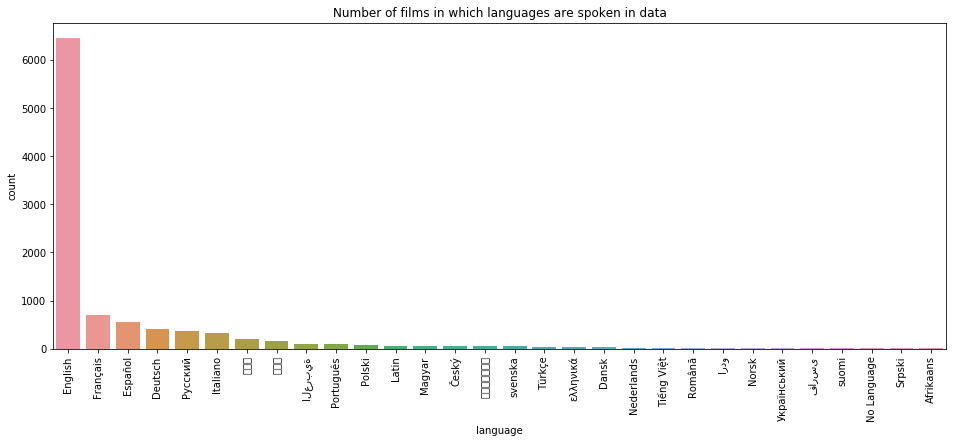

In [28]:
spoken_languages = data.spoken_languages.fillna('').apply(lambda x: name_regex.findall(x))
all_languages = [lang for langs in spoken_languages for lang in langs]
counts = np.unique(all_languages, return_counts = True)
counts = pd.DataFrame(np.vstack(counts).T, columns=['language', 'count'])
counts['count'] = counts['count'].astype('int')

plt.figure(figsize=(16, 6))
plt.subplot(1, 1, 1)
g = sns.barplot('language', 'count', data = counts.sort_values(by='count', ascending = False).head(30))
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
plt.title('Number of films in which languages are spoken in data')
plt.show()

English dominates the language distribution and seems a good candidate for a feature.

One potentially useful kind of information which came to my mind was to add external data of the number of native speakers by language. It seems reasonable to assume that, for example, if Russian was spoken in a film, it would attract more people to the cinemas in Russia, and the added revenue would be correlated with the number of native Russian speakers. Unfortunately, I couldn't find a useful database with this information which could be linked to the data in this competition. The data does contain the ISO 639-1 code of the spoken languages, but as of the time of writing, there is no (at least that I could find) readily available database which used this standard of language code.

Considering alternative uses of this column, perhaps the diversity of languages somehow relates to revenue?

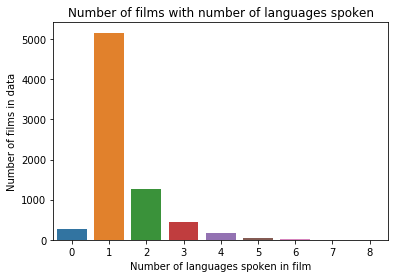

In [29]:
data['n_langs'] = [len(sl) for sl in spoken_languages]
n_langs_counts = np.unique(data['n_langs'], return_counts = True)
sns.barplot(x = n_langs_counts[0], y = n_langs_counts[1])
plt.title('Number of films with number of languages spoken')
plt.xlabel('Number of languages spoken in film')
plt.ylabel('Number of films in data')
plt.show()

Let's create some language features:

In [30]:
iso_regex = re.compile('(?<=\'iso_639_1\': )\'(\\w+)\'')
spoken_lang_codes = data.spoken_languages.fillna('').apply(lambda x: iso_regex.findall(x))
lang_codes_counts = [lcc for row in spoken_lang_codes for lcc in row]
lang_codes_counts = np.unique(lang_codes_counts, return_counts = True)

most_common_langs = lang_codes_counts[0][lang_codes_counts[1] > 300]
for lang in most_common_langs:
    col_name = f'lang_{lang.upper()}'
    data[col_name] = [lang in langs for langs in spoken_languages]
    
data = data.drop('spoken_languages', axis = 1)

Next, we look at cast and crew. Basing features on whether a specific actor was in the production seems complicated and...suboptimal to me. First of all this hypothetical feature, although it might be a good indicator for a potential blockbuster if a certain star was in the film, would fluctuate so much during the years (together with the person's level of stardom). The model would somehow have to be updated periodically to reflect that person's stock in the business. Not to mention that it would be completely useless once they retire, or for the vast majority of films, in which he/she has no part. Nevertheless, let's check who the most common actors in the data are, at least for fun if little else.

In [31]:
cast_name_regex = re.compile('(?<=\'name\': )\'([\\w ]+)\'')
cast_names = data.cast.fillna('').apply(lambda x: cast_name_regex.findall(x))

all_actors = [actor for actors in cast_names for actor in actors]
all_actors = np.unique(all_actors, return_counts = True)
all_actors = np.hstack((all_actors[0].reshape(-1, 1), all_actors[1].reshape(-1, 1)))
all_actors = all_actors[all_actors[:, 1].astype('int').argsort()][::-1]

all_actors[:15]

array([['Robert De Niro', '71'],
       ['Bruce Willis', '62'],
       ['Morgan Freeman', '61'],
       ['Liam Neeson', '57'],
       ['Steve Buscemi', '55'],
       ['Willem Dafoe', '55'],
       ['Nicolas Cage', '54'],
       ['Sylvester Stallone', '54'],
       ['Matt Damon', '51'],
       ['Christopher Walken', '50'],
       ['Julianne Moore', '50'],
       ['John Goodman', '50'],
       ['Robin Williams', '50'],
       ['Johnny Depp', '48'],
       ['Stanley Tucci', '47']], dtype='<U33')

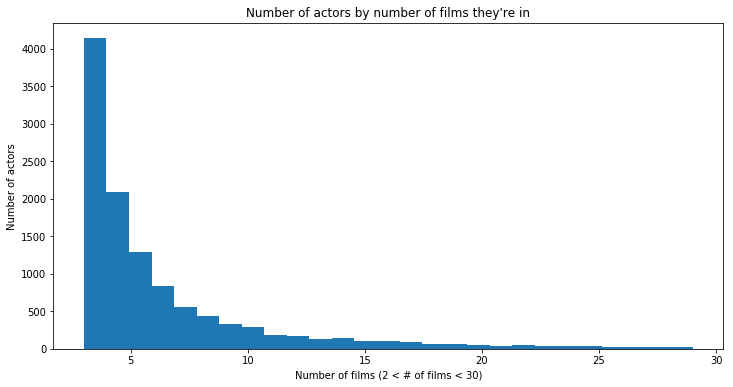

In [32]:
actor_nmovies = all_actors[:, 1].astype('int')

plt.rcParams['figure.figsize'] = [12, 6]
plt.hist(actor_nmovies[(actor_nmovies > 2)&(actor_nmovies < 30)], bins = 27)
plt.title('Number of actors by number of films they\'re in')
plt.xlabel('Number of films (2 < # of films < 30)')
plt.ylabel('Number of actors')
plt.show()

My thoughts on the "crew" column mirror those for "cast". I'm sure that a good director, and good crew overall, would correlate greatly with box office success. The difficulty is in measuring this "goodness", accurately through time.

There are, however, a few additional, objective features which I saw from Andrew Lukyanenko's kernel, to which I will again post a link below.

In [33]:
# features adapted from https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

gender_regex = re.compile('(?<=\'gender\': )(\\d)')
sum_gender = lambda x, y: sum([1 for m in gender_regex.findall(x) if int(m) == y])

crew_fillna = data['crew'].fillna('')
cast_fillna = data['cast'].fillna('')
data['genders_0_crew'] = crew_fillna.apply(lambda x: sum_gender(x, 0))
data['genders_1_crew'] = crew_fillna.apply(lambda x: sum_gender(x, 1))
data['genders_2_crew'] = crew_fillna.apply(lambda x: sum_gender(x, 2))
data['genders_0_cast'] = cast_fillna.apply(lambda x: sum_gender(x, 0))
data['genders_1_cast'] = cast_fillna.apply(lambda x: sum_gender(x, 1))
data['genders_2_cast'] = cast_fillna.apply(lambda x: sum_gender(x, 2))
data['num_crew'] = crew_fillna.apply(lambda x: len(id_regex.findall(x)))
data['num_cast'] = cast_fillna.apply(lambda x: len(id_regex.findall(x)))

data = data.drop(['crew', 'cast'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 64 columns):
id                 7398 non-null int64
budget             7398 non-null int64
imdb_id            7398 non-null object
overview           7376 non-null object
popularity         7398 non-null float64
release_date       7397 non-null object
runtime            7392 non-null float64
tagline            5938 non-null object
title              7395 non-null object
keywords           6729 non-null object
revenue            7398 non-null int64
in_collection      7398 non-null bool
multi_genre        7398 non-null int64
genre_count        7398 non-null int64
genre_drama        7398 non-null bool
genre_comedy       7398 non-null bool
genre_thriller     7398 non-null bool
genre_action       7398 non-null bool
genre_romance      7398 non-null bool
genre_adventure    7398 non-null bool
genres_na          7398 non-null bool
has_homepage       7398 non-null bool
language_en        7398 non-null b

There are three text columns, excluding "title" - "overview", "keywords" and "tagline". An easy and useful way to extract potentially useful information from text if by using TF-IDF. This is precisely what I've done below, then using SVD to choose a workable subset of features and ensure they are the most useful of the bunch.

In [34]:
def get_tfidf_features(train, test, n_components, ngram_range = (1, 3)):
    tfv = TfidfVectorizer(min_df = 5,  max_features=None,
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range= ngram_range, use_idf = True, smooth_idf = True, sublinear_tf = True,
            stop_words = 'english')

    # Fit TFIDF
    tfv.fit(list(train) + list(test))
    tf_train =  tfv.transform(train)
    tf_test = tfv.transform(test)

    svd = TruncatedSVD(n_components = n_components, random_state = 10)
    svd.fit(tf_train)
    tf_train = svd.transform(tf_train)
    tf_test = svd.transform(tf_test)
    return tf_train, tf_test

In [35]:
data['num_keywords'] = data.keywords.fillna('').apply(lambda x: len(id_regex.findall(x)))
data['tagline_len'] = data.tagline.fillna('').apply(lambda x: len(x))
data['overview_len'] = data.overview.fillna('').apply(lambda x: len(x))

train_overview = data[data.revenue != -1].overview.fillna('none').values
test_overview = data[data.revenue == -1].overview.fillna('none').values

# features from overview column
n_components = 12
tf_train, tf_test = get_tfidf_features(train_overview, test_overview, n_components = n_components)

for i in range(1, n_components + 1):
    data.loc[data.revenue != -1, f'overview_tfidf_{i}'] = tf_train[:, i - 1]
    data.loc[data.revenue == -1, f'overview_tfidf_{i}'] = tf_test[:, i - 1]

# features from tagline column
n_components = 3
train_tagline = data[data.revenue != -1].tagline.fillna('none').values
test_tagline = data[data.revenue == -1].tagline.fillna('none').values

tf_train, tf_test = get_tfidf_features(train_tagline, test_tagline, n_components = n_components)

for i in range(1, n_components + 1):
    data.loc[data.revenue != -1, f'tagline_tfidf_{i}'] = tf_train[:, (i - 1)]
    data.loc[data.revenue == -1, f'tagline_tfidf_{i}'] = tf_test[:, (i - 1)]

# features from keywords column
n_components = 2
multiword_name_regex = re.compile('(?<=\'name\': )\'([\\w ]+)\'')
train_keywords = data[data.revenue != -1]\
                    .keywords.fillna('').apply(lambda x: ' '.join(['-'.join(words.split())\
                                                for words in multiword_name_regex.findall(x)]))
test_keywords = data[data.revenue == -1]\
                    .keywords.fillna('').apply(lambda x: ' '.join(['-'.join(words.split())\
                                                for words in multiword_name_regex.findall(x)]))
    
tf_train, tf_test = get_tfidf_features(train_keywords, test_keywords, n_components = n_components)

for i in range(1, n_components + 1):
    data.loc[data.revenue != -1, f'keywords_tfidf_{i}'] = tf_train[:, i - 1]
    data.loc[data.revenue == -1, f'keywords_tfidf_{i}'] = tf_test[:, i - 1]

When it comes to the "runtime" and "release_date" features, there were only a few missing values (six and one respectively). This was easy to fix manually (thanks, Google!). I also create some features based on the release date.

In [36]:
# manually fix some NaN film runtimes
data.loc[data.title == 'Королёв', 'runtime'] = 120
data.loc[data.title == 'Happy Weekend', 'runtime'] = 90
data.loc[data.title == 'La caliente niña Julietta', 'runtime'] = 93
data.loc[data.title == 'Pancho, el perro millonario', 'runtime'] = 91
data.loc[data.title == 'Nunca en horas de clase', 'runtime'] = 100
data.loc[data.title == 'Miesten välisiä keskusteluja', 'runtime'] = 116

data.loc[data.release_date.isna(), 'release_date'] = '3/20/01'
data['release_date'] = data.release_date.apply(fix_date)
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data.release_date.apply(lambda x: pd.to_datetime(x).year)
data['release_month'] = data.release_date.apply(lambda x: pd.to_datetime(x).month)
data['release_dayofweek'] = data.release_date.apply(lambda x: pd.to_datetime(x).dayofweek)
data['release_quarter'] = data.release_date.apply(lambda x: pd.to_datetime(x).quarter)

data = data.drop(['id', 'tagline', 'keywords', 'overview', 'title', 'imdb_id', 'release_date'], axis = 1)

The budgets of films vary greatly. Some are in the thousands, others consume hundreds of millions. Therefore, I found it useful to take the natural log of the budget.

In [37]:
# feature inspired from https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
data['log_budget'] = np.log1p(data['budget'])
data = data.drop('budget', axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 81 columns):
popularity           7398 non-null float64
runtime              7398 non-null float64
revenue              7398 non-null int64
in_collection        7398 non-null bool
multi_genre          7398 non-null int64
genre_count          7398 non-null int64
genre_drama          7398 non-null bool
genre_comedy         7398 non-null bool
genre_thriller       7398 non-null bool
genre_action         7398 non-null bool
genre_romance        7398 non-null bool
genre_adventure      7398 non-null bool
genres_na            7398 non-null bool
has_homepage         7398 non-null bool
language_en          7398 non-null bool
countries_US         7398 non-null bool
countries_GB         7398 non-null bool
countries_FR         7398 non-null bool
countries_DE         7398 non-null bool
countries_CA         7398 non-null bool
countries_IN         7398 non-null bool
countries_ROW        7398 non-null bool
coun

Finally, it is time to train and optimize the model! Due to the scarcity of data, I ruled out neural networks from the start. Gradient boosting algorithms usually work best in these conditions, which is why I went with lightgbm and xgboost. 

In [38]:
def train_model(X_train, y_train, model_type, params, n_splits = 6):
    if n_splits > 1:
        kfold = KFold(n_splits = n_splits, random_state = 42)
        splits = kfold.split(X_train, y_train)
    else:    
        train_index, valid_index = train_test_split(list(X_train.index),
                                                    train_size = 0.8,
                                                    random_state = 42)
        splits = [(train_index, valid_index)]
    
    val_rmse = []
    oof = np.zeros(X_train.shape[0])
    fi = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_tr = X_train.iloc[train_index, :]
        X_val = X_train.iloc[valid_index, :]

        y_tr = y_train[train_index]
        y_val = y_train[valid_index]
        
        if model_type == 'lgb':
            d_train = lgb.Dataset(X_tr, label = y_tr)
            d_valid = lgb.Dataset(X_val, label = y_val)
            watchlist = [d_train, d_valid]
            
            model = lgb.train(params,
                              train_set = d_train,
                              num_boost_round = num_rounds,
                              valid_sets = watchlist,
                              verbose_eval = verbose_eval,
                              early_stopping_rounds = early_stop)
            
            val_pred = model.predict(X_val, num_iteration = model.best_iteration)        
            oof[valid_index] = val_pred.reshape(-1,)
            
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["cols"] = X_train.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            fi = pd.concat([fi, fold_importance], axis=0)
        elif model_type == 'xgb':
            d_train = xgb.DMatrix(X_tr, label = y_tr)
            d_valid = xgb.DMatrix(X_val, label = y_val)
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            model = xgb.train(params,
                                dtrain = d_train,
                                num_boost_round = num_rounds,
                                evals = watchlist,
                                verbose_eval = verbose_eval,
                                early_stopping_rounds = early_stop)

        
            val_pred = model.predict(d_valid)   
            oof[valid_index] = val_pred.reshape(-1,)
            
            fi = None
        else:
            model = RidgeCV(**params)
            model.fit(X_tr.values, y_tr)
            
            val_pred = model.predict(X_val.values)

        last_rmse = rmse(y_val, val_pred)
        val_rmse.append(last_rmse)
    
    if model_type == 'lgb':
        fi = fi[['cols', 'importance']].groupby('cols').mean()\
                                        .sort_values(by = 'importance', ascending = False)
        fi = pd.DataFrame(np.array([fi.index.values, fi.importance.values]).T,
                          columns = ['cols', 'importance'])
        
    print('Average Validation RMSE: {}'.format(sum(val_rmse) / len(val_rmse)))
    return model, oof, fi

def split_data(data):
    train = data[data.revenue != -1]
    X_train, y_train = train.drop('revenue', axis = 1), np.log(train['revenue'].values)
    X_test = data[data.revenue == -1].drop('revenue', axis = 1)
    
    return X_train, y_train, X_test

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def rmse(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(y_pred[i] - y[i]) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def feat_importance(model, df):
    return pd.DataFrame({'cols': df.columns, 'importance': model.feature_importance()}
                        ).sort_values('importance', 6ascending=False)

def plot_feat_importance(fi, figsize = (12, 8), xticks = np.arange(0, 100, 5)):
    return fi.plot('cols', 'importance', 'barh',
                   figsize = figsize,
                   legend = False,
                   xticks = xticks)

In [39]:
X_train, y_train, X_test = split_data(data)

The parameters and training scores of the first run of LGBM (after some parameter optimization) can be seen below:

In [40]:
params_lgb = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 30,
    'min_data_in_leaf': 10,
    'max_depth': 4,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.4,
#     'min_split_gain': 0.002,
    'min_child_samples': 146,
#     'min_child_weight': 0.001,
#     'lambda_l2': 2200,
    'lambda_l1': 0.2,
    'verbosity': -1,
    'data_random_seed': 17
}

# Additional parameters:
early_stop = 300
verbose_eval = 100
num_rounds = 10000

model_lgb, _, fi = train_model(X_train, y_train, 'lgb', params_lgb)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.22572	valid_1's rmse: 2.43283
[200]	training's rmse: 1.91844	valid_1's rmse: 2.22041
[300]	training's rmse: 1.75653	valid_1's rmse: 2.14464
[400]	training's rmse: 1.64838	valid_1's rmse: 2.09232
[500]	training's rmse: 1.56658	valid_1's rmse: 2.05139
[600]	training's rmse: 1.50664	valid_1's rmse: 2.03268
[700]	training's rmse: 1.46027	valid_1's rmse: 2.02535
[800]	training's rmse: 1.42219	valid_1's rmse: 2.02283
[900]	training's rmse: 1.3863	valid_1's rmse: 2.0194
[1000]	training's rmse: 1.35363	valid_1's rmse: 2.01775
[1100]	training's rmse: 1.31799	valid_1's rmse: 2.01572
[1200]	training's rmse: 1.28625	valid_1's rmse: 2.01531
[1300]	training's rmse: 1.25509	valid_1's rmse: 2.01676
[1400]	training's rmse: 1.22743	valid_1's rmse: 2.01597
Early stopping, best iteration is:
[1173]	training's rmse: 1.29571	valid_1's rmse: 2.01506
Training until validation scores don't improve for 300 rounds.
[100]	trai

In [41]:
# corr = np.round(spearmanr(X_train).correlation , 4)
# corr = np.array([1e-8 if np.isnan(c) else c for cc in corr for c in cc]).reshape(corr.shape)
# for i in range(len(corr)):
#     corr[i, i] = 1.0
# corr_condensed = hc.distance.squareform(1 - corr)
# z = hc.linkage(corr_condensed, method = 'average')
# fig = plt.figure(figsize = (16, 16))
# dendrogram = hc.dendrogram(z, labels = X_train.columns, orientation = 'left', leaf_font_size = 14)
# plt.show()

Let's see if this result can be improved. Looking at feature importance:

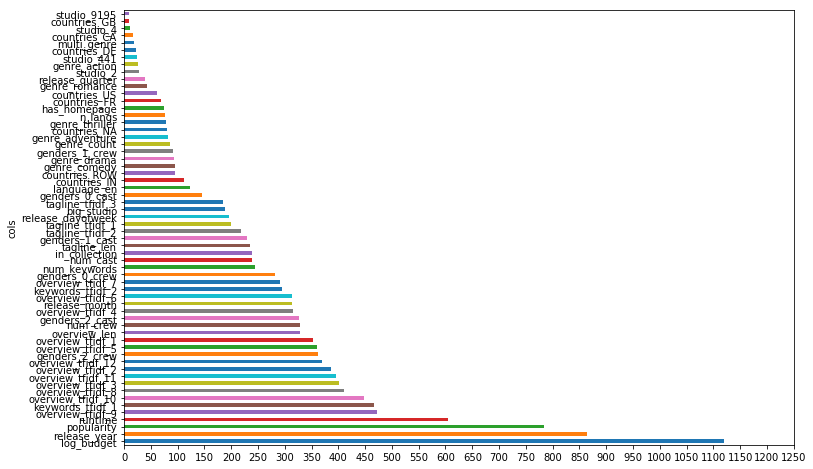

In [42]:
plot_feat_importance(fi[:60], xticks = np.arange(0, 1300, 50))

There are definitely a lot of features with little to no importance. Applying Occam's razor, let's try and get rid of the least important columns:

In [43]:
unimportant_cols = fi[fi.importance < 60]['cols']
unimportant_cols

49      genre_romance
50    release_quarter
51           studio_2
52       genre_action
53         studio_441
54       countries_DE
55        multi_genre
56       countries_CA
57           studio_4
58       countries_GB
59        studio_9195
60          studio_33
61        studio_7295
62          studio_12
63        studio_5358
64          studio_79
65           studio_5
66         studio_306
67        studio_8411
68        studio_6194
69          studio_14
70            lang_DE
71            lang_EN
72          studio_60
73         studio_559
74            lang_ES
75          genres_na
76            lang_IT
77            lang_FR
78            lang_RU
79         studio_508
Name: cols, dtype: object

In [44]:
X_train = X_train.drop(unimportant_cols, axis = 1)
X_test = X_test.drop(unimportant_cols, axis = 1)

In [45]:
model_lgb, oof_lgb, fi = train_model(X_train, y_train, 'lgb', params_lgb)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.22846	valid_1's rmse: 2.43546
[200]	training's rmse: 1.93114	valid_1's rmse: 2.22837
[300]	training's rmse: 1.7625	valid_1's rmse: 2.13403
[400]	training's rmse: 1.65225	valid_1's rmse: 2.08298
[500]	training's rmse: 1.57573	valid_1's rmse: 2.05017
[600]	training's rmse: 1.51523	valid_1's rmse: 2.03229
[700]	training's rmse: 1.46802	valid_1's rmse: 2.0218
[800]	training's rmse: 1.42521	valid_1's rmse: 2.01943
[900]	training's rmse: 1.38526	valid_1's rmse: 2.01509
[1000]	training's rmse: 1.34733	valid_1's rmse: 2.01529
[1100]	training's rmse: 1.31338	valid_1's rmse: 2.0132
[1200]	training's rmse: 1.28274	valid_1's rmse: 2.01505
[1300]	training's rmse: 1.25387	valid_1's rmse: 2.01539
Early stopping, best iteration is:
[1089]	training's rmse: 1.31653	valid_1's rmse: 2.01287
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.25762	valid_1's rmse: 2.25386
[200]	traini

Cutting the features with smallest importance did give a slightly worse average validation set RMSE score, but in my view the difference is small enough that we can give priority to the simpler model. Now, let's look at XGBoost, which again has parameters already optimized:

In [46]:
params = {
    'application': 'regression',
    'boosting': 'gbtree',
#     'rate_drop': 0.8,
#     'sample_type': 'weighted',
#     'normalize_type': 'forest',
    'n_estimators': 20000,
    'metric': 'rmse',
    'gamma': 10,
    'max_depth': 6,
#     'min_child_weight': 1,
    'learning_rate': 0.01,
#     'eta': 0.99,
#     'max_leaves': 100,
    'lambda': 1e-2,
    'verbosity': -1,
    'nthread': 4,
    'seed': 17
}

# Additional parameters:
early_stop = 300
verbose_eval = 100
num_rounds = 10000
n_splits = 6

model_xgb, oof_xgb, _ = train_model(X_train, y_train, 'xgb', params)

[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[0]	train-rmse:15.6369	valid-rmse:15.57
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 300 rounds.
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\

[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 28 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 26 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 24 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 30 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 24 pruned nodes, max_depth=6
[11:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 42 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 36 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 40 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 30 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 42 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 38 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 48 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 50 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 48 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 44 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 48 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 40 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 40 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 56 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 44 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 54 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 44 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 48 pruned nodes, max_depth=6
[11:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 46 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 42 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 44 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 52 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 38 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 52 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 54 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 48 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 52 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 58 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 56 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 54 pruned nodes, max_depth=6
[11:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 56 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 46 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 46 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 28 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 26 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 54 pruned nodes, max_depth=6
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 24 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 34 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 22 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 28 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 28 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 22 pruned nodes, max_depth=6
[11:02:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 24 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 26 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 24 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 28 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 30 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 36 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 44 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 26 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 24 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 46 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 44 pruned nodes, max_depth=6
[11:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 44 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 42 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 56 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 54 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 54 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 50 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 34 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 38 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 32 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 52 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 50 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 38 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 38 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 70 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 60 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 48 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 84 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 54 pruned nodes, max_depth=6
[11:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 46 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 60 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 28 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 50 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 28 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 60 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 54 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 34 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 46 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 20 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 36 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 46 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 22 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 34 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 96 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 54 pruned nodes, max_depth=6
[11:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 30 pruned nodes, max_depth=6
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 56 pruned nodes, max_depth=6
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 18 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 28 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 28 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 40 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 28 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 18 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 38 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 28 pruned nodes, max_depth=6
[11:02:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 26 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 46 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 34 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 44 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 30 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 32 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 44 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 50 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 32 pruned nodes, max_depth=6
[200]	train-rmse:2.52417	valid-rmse:3.02849
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 44 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 44 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 34 pruned nodes, max_depth=6
[11:02:40] C:\Users\Administrator\Desktop\xg

[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 52 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 42 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 42 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 52 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 52 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 54 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 50 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 46 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 52 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 48 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 50 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 46 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 48 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 44 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 44 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 62 pruned nodes, max_depth=6
[11:02:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 42 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 58 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 54 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 38 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 48 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 46 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 76 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 66 pruned nodes, max_depth=6
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 12 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 16 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 14 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 16 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 12 pruned nodes, max_depth=6
[11:02:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 38 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 20 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 18 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 24 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 34 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 18 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 34 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 30 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 36 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 30 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 34 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 34 pruned nodes, max_depth=6
[11:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 48 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 38 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 46 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 52 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 40 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 60 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 50 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 48 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 58 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 46 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 42 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 48 pruned nodes, max_depth=6
[11:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 40 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 46 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 42 pruned nodes, max_depth=6
[300]	train-rmse:1.49089	valid-rmse:2.14758
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 46 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 52 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xg

[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 38 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 66 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 60 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 66 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 68 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 44 pruned nodes, max_depth=6
[11:02:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 50 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 48 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 52 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 40 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 52 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 60 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 36 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 50 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 50 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 58 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 56 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 70 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 86 pruned nodes, max_depth=2
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 52 pruned nodes, max_depth=6
[11:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 22 pruned nodes, max_depth=6
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 74 pruned nodes, max_depth=6
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 92 pruned nodes, max_depth=5
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[11:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=6
[0]	train-rmse:15.6132	valid-rmse:15.6894
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 300 rounds.
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 16 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 14 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\sr

[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 18 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 18 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 26 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 20 pruned nodes, max_depth=6
[11:02:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 26 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 30 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 28 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 28 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 30 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 26 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 32 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 42 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 36 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 42 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 24 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 42 pruned nodes, max_depth=6
[11:02:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 66 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 22 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 46 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 46 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 60 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 34 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 44 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 36 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 46 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 44 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 32 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 24 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 44 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 60 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 36 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 62 pruned nodes, max_depth=6
[11:03:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 42 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 68 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 40 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 44 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 46 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 60 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 46 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 56 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 24 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 68 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 50 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 18 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 78 pruned nodes, max_depth=6
[11:03:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 42 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 76 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 32 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 38 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 36 pruned nodes, max_depth=6
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[800]	train-rmse:1.0779	valid-rmse:1.88901
[11:03:04] C:\Users\Administrator\Desktop\xgboost\s

[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 68 pruned nodes, max_depth=0
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 12 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 12 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 14 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 14 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 14 pruned nodes, max_depth=6
[11:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 26 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 22 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 20 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 30 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 22 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 20 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 52 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 28 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 36 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 34 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 34 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 52 pruned nodes, max_depth=6
[11:03:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 54 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 44 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 58 pruned nodes, max_depth=6
[200]	train-rmse:2.5366	valid-rmse:2.88937
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 42 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 44 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 40 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgb

[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 34 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 34 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 42 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 34 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 40 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 40 pruned nodes, max_depth=6
[11:03:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 40 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 50 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 40 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 42 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 36 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 64 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 62 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 52 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 44 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 42 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 48 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 48 pruned nodes, max_depth=6
[11:03:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 64 pruned nodes, max_depth=6
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 78 pruned nodes, max_depth=6
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 34 pruned nodes, max_depth=6
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 52 pruned nodes, max_depth=6
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 70 pruned nodes, max_depth=6
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[500]	train-rmse:1.11844	valid-rmse:1.88118
[11:03:11] C:\Users\Administrator\Desktop\xgboost\

[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 54 pruned nodes, max_depth=6
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 78 pruned nodes, max_depth=6
[11:03:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[900]	train-rmse:1.11199	valid-rmse:1.87116
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:14] C:\Users\Administrator\Desktop\xgboost\

[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[1300]	train-rmse:1.11199	valid-rmse:1.87102
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost

[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[11:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
Stopping. Best iteration:
[1296]	train-rmse:1.11199	valid-rmse:1.87102

Average Validation RMSE: 1.988042363451121


XGBoost seems to perform worse than LGBM on average. Nevertheless, their combined predictive power might still be better than either of them alone.

Before that, I wanted to get some visual confirmation that the models are at least doing something reasonable. In the cell below I've plotted the distributions of out-of-fold predictions of LGBM, XGB and the true training target distribution.

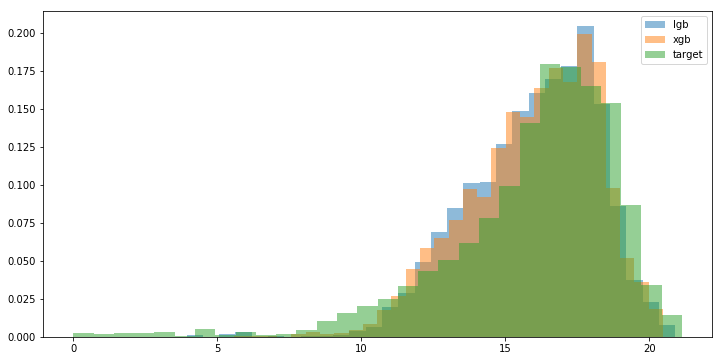

In [47]:
plt.hist(oof_lgb, bins = 30, alpha = 0.5, label = 'lgb', density = True)
plt.hist(oof_xgb, bins = 30, alpha = 0.5, label = 'xgb', density = True)
plt.hist(y_train, bins = 30, alpha = 0.5, label = 'target', density = True)
plt.legend()
plt.show()

Of course the distributions have differences (otherwise the RMSE validation error would have been close to zero). However, they at least seem unimodal (like the target distribution) and with similar mean, variance and skew.

But what if the outliers in the data were harming the results? Boosting algorithms are known to be particularly sensitive to outliers (because each successive tree focusses on the previous tree's residuals/errors and otliers have particularly high residuals, so will attract a lot of attention).

Let's look at the kind of films that have extraordinary revenues

In [48]:
data_raw = pd.read_csv('train.csv')
revenue_mean = data_raw.revenue.mean()
outliers = data_raw[(data_raw.revenue < revenue_mean - 5 * data_raw.revenue.std())|\
         (data_raw.revenue > revenue_mean + 5 * data_raw.revenue.std())][['title',
                                                                          'release_date',
                                                                          'revenue']]

no_outliers = data_raw[(data_raw.revenue > revenue_mean - 5 * data_raw.revenue.std())&\
                       (data_raw.revenue < revenue_mean + 5 * data_raw.revenue.std())][[
                                                                            'title',
                                                                            'release_date',
                                                                            'revenue']]
outliers.revenue /= 1e9
outliers[:20]

,title,release_date,revenue
114,The Lord of the Rings: The Fellowship of the Ring,12/18/01,0.871368
357,The Lion King,6/23/94,0.788242
518,Wonder Woman,5/30/17,0.820580
543,The Lord of the Rings: The Two Towers,12/18/02,0.926287
666,The Hobbit: The Desolation of Smaug,12/11/13,0.958400
684,Beauty and the Beast,3/16/17,1.262886
689,Star Wars: Episode III - Revenge of the Sith,5/17/05,0.850000
734,Zootopia,2/11/16,1.023784
881,Alice in Wonderland,3/3/10,1.025491
902,Indiana Jones and the Kingdom of the Crystal S...,5/21/08,0.786636


Unsurprisingly, the biggest outliers are Hollywood blockbusters. No low-budget films appear on the list because five standard deviations from the mean revenue would take them to negative earnings!

Let's try removing these outliers and see if the model performs better:

In [49]:
train_no_outliers = X_train.drop(outliers.index.tolist(), axis = 0)
y_tr_no_outliers = np.log(np.array(no_outliers.revenue.tolist()))
model_lgb_noout = train_model(train_no_outliers, y_tr_no_outliers, 'lgb', params_lgb)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.2944	valid_1's rmse: 2.55046
[200]	training's rmse: 2.00643	valid_1's rmse: 2.35904
[300]	training's rmse: 1.83755	valid_1's rmse: 2.27885
[400]	training's rmse: 1.71952	valid_1's rmse: 2.229
[500]	training's rmse: 1.63602	valid_1's rmse: 2.19967
[600]	training's rmse: 1.57472	valid_1's rmse: 2.19105
[700]	training's rmse: 1.52562	valid_1's rmse: 2.18662
[800]	training's rmse: 1.4797	valid_1's rmse: 2.18706
[900]	training's rmse: 1.44039	valid_1's rmse: 2.18823
[1000]	training's rmse: 1.40323	valid_1's rmse: 2.19037
Early stopping, best iteration is:
[728]	training's rmse: 1.51284	valid_1's rmse: 2.1861
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.34115	valid_1's rmse: 2.2984
[200]	training's rmse: 2.04301	valid_1's rmse: 2.11097
[300]	training's rmse: 1.86676	valid_1's rmse: 2.01173
[400]	training's rmse: 1.75589	valid_1's rmse: 1.95254
[500]	training's rm

Model actually got quite a bit worse, so we're keeping the blockbusters!

Finally, let's create some additional, slightly different models, in the hope that they'll capture different features of the data distribution.

In [50]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 30,
    'min_data_in_leaf': 10,
    'max_depth': 6,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
#     'min_split_gain': 0.002,
    'min_child_samples': 146,
#     'min_child_weight': 0.001,
#     'lambda_l2': 2200,
    'lambda_l1': 0.2,
    'verbosity': -1,
    'data_random_seed': 25,
    'verbose_eval': False,
    'verbose': False
}
model_lgb2, oof_lgb2, _ = train_model(X_train, y_train, 'lgb', params)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.09917	valid_1's rmse: 2.40707
[200]	training's rmse: 1.71552	valid_1's rmse: 2.20934
[300]	training's rmse: 1.49508	valid_1's rmse: 2.14158
[400]	training's rmse: 1.33825	valid_1's rmse: 2.08779
[500]	training's rmse: 1.22685	valid_1's rmse: 2.05929
[600]	training's rmse: 1.1418	valid_1's rmse: 2.04841
[700]	training's rmse: 1.06971	valid_1's rmse: 2.03774
[800]	training's rmse: 1.00954	valid_1's rmse: 2.03519
[900]	training's rmse: 0.95737	valid_1's rmse: 2.03366
[1000]	training's rmse: 0.908058	valid_1's rmse: 2.03359
[1100]	training's rmse: 0.865619	valid_1's rmse: 2.03438
[1200]	training's rmse: 0.826879	valid_1's rmse: 2.03372
Early stopping, best iteration is:
[939]	training's rmse: 0.937758	valid_1's rmse: 2.03283
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.12727	valid_1's rmse: 2.22724
[200]	training's rmse: 1.73646	valid_1's rmse: 2.02974
[300]	tr

In [51]:
params['max_depth'] = 8
params['num_leaves'] = 20
params['data_random_seed'] = 42
model_lgb3, oof_lgb3, _ = train_model(X_train, y_train, 'lgb', params)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.1463	valid_1's rmse: 2.41226
[200]	training's rmse: 1.78466	valid_1's rmse: 2.21334
[300]	training's rmse: 1.58371	valid_1's rmse: 2.1448
[400]	training's rmse: 1.43498	valid_1's rmse: 2.10809
[500]	training's rmse: 1.32391	valid_1's rmse: 2.08055
[600]	training's rmse: 1.23976	valid_1's rmse: 2.06391
[700]	training's rmse: 1.16701	valid_1's rmse: 2.05692
[800]	training's rmse: 1.10545	valid_1's rmse: 2.05139
[900]	training's rmse: 1.05267	valid_1's rmse: 2.05088
[1000]	training's rmse: 1.00421	valid_1's rmse: 2.05273
[1100]	training's rmse: 0.959429	valid_1's rmse: 2.05247
Early stopping, best iteration is:
[817]	training's rmse: 1.09565	valid_1's rmse: 2.05071
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.17603	valid_1's rmse: 2.23667
[200]	training's rmse: 1.8057	valid_1's rmse: 2.03385
[300]	training's rmse: 1.60017	valid_1's rmse: 1.95332
[400]	training

Training another LGBM on top of the results of the previous models:

In [52]:
train_stack = np.vstack([oof_lgb, oof_lgb2, oof_lgb3, oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'lgb2', 'lgb3', 'xgb'])

params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 30,
    'min_data_in_leaf': 6,
    'max_depth': 2,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.9,
#     'min_split_gain': 0.002,
    'min_child_samples': 100,
#     'min_child_weight': 0.001,
#     'lambda_l2': 2200,
    'lambda_l1': 0.2,
    'verbosity': -1,
    'data_random_seed': 36
}

# Additional parameters:
early_stop = 300
verbose_eval = 100
num_rounds = 10000

model_stack, _, fi = train_model(train_stack, y_train, 'lgb', params)

Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.09519	valid_1's rmse: 2.23287
[200]	training's rmse: 1.87967	valid_1's rmse: 2.04462
[300]	training's rmse: 1.82572	valid_1's rmse: 2.01538
[400]	training's rmse: 1.80829	valid_1's rmse: 2.01194
[500]	training's rmse: 1.79799	valid_1's rmse: 2.01341
[600]	training's rmse: 1.79055	valid_1's rmse: 2.01469
Early stopping, best iteration is:
[386]	training's rmse: 1.81012	valid_1's rmse: 2.01159
Training until validation scores don't improve for 300 rounds.
[100]	training's rmse: 2.12858	valid_1's rmse: 2.07906
[200]	training's rmse: 1.91346	valid_1's rmse: 1.88909
[300]	training's rmse: 1.85763	valid_1's rmse: 1.85059
[400]	training's rmse: 1.83936	valid_1's rmse: 1.84044
[500]	training's rmse: 1.83044	valid_1's rmse: 1.83863
[600]	training's rmse: 1.82264	valid_1's rmse: 1.83962
[700]	training's rmse: 1.8157	valid_1's rmse: 1.84363
[800]	training's rmse: 1.8085	valid_1's rmse: 1.84633
Early stopping, 

Training a linear regression model on the results of the previous models:

In [53]:
params = {
    'alphas': (0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
    'scoring': 'neg_mean_squared_error',
    'cv': 6
}

model_rcv, _, _ = train_model(train_stack, y_train, 'linear', params)

Average Validation RMSE: 1.885038723120724


Spoiler alert: stacking models did not lead to an improved test set score in the competition. The best score I got was 1.97204 RMSLE from the single LGBM model (the first one) and, as of the time of writing, gets me into the top 25% of the competition, without using additional data or external features. FYI, the ridge regression model was only marginally worse, and the LGBM stacked model was third.

In [54]:
lgb_test = model_lgb.predict(X_test)
lgb2_test = model_lgb2.predict(X_test)
lgb3_test = model_lgb3.predict(X_test)
xgb_test = model_xgb.predict(xgb.DMatrix(X_test))
test_stack = pd.DataFrame(np.vstack([lgb_test, lgb2_test, lgb3_test, xgb_test]).transpose(),
                           columns = ['lgb', 'lgb2', 'lgb3', 'xgb'])
ridge_test_preds = model_rcv.predict(test_stack)
lgb_stack_preds = model_stack.predict(test_stack)

test_ids = pd.read_csv('test.csv').id
preds = np.exp(lgb_test)

submission = pd.DataFrame({'id': test_ids, 'revenue': preds.astype(np.int64)})
submission.head()
submission.to_csv('submission.csv', index=False)